In [1]:
import numpy as np
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import datetime
import zulu
import os
pd.set_option('display.float_format', '{:.4f}'.format)

ID = '101-004-9949998-001'
token = '4900a27fe17ab573d490ce234465329f-6633f44d08bf25b48ceaacd2c7917674'

client = oandapyV20.API(access_token=token)

In [2]:
# Loop to create the dataset
Date = pd.Series(datetime.datetime(2010, 1, 1, 0, 0, 0))
eurusd = pd.DataFrame()


while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 5:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(minutes=5)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "M5"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    eurusd = eurusd.append(newEurusd)

In [3]:
eurusd.head()

,Time,Open,High,Low,Close
0,2010-01-03 17:50:00,1.43120,1.43120,1.43120,1.43120
1,2010-01-03 17:55:00,1.43172,1.43172,1.43172,1.43172
2,2010-01-03 18:00:00,1.43172,1.43328,1.43172,1.43328
3,2010-01-03 18:05:00,1.43323,1.43425,1.43150,1.43150
4,2010-01-03 18:10:00,1.43105,1.43150,1.43105,1.43110


In [230]:
#eurusd.to_csv(os.getcwd()+'\\eurusd5min.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd5min.csv', index_col=0)

In [231]:
# Exponential Moving Averages
eurusd["ema40"] = eurusd["Close"].ewm(span=40, min_periods=40, adjust=False).mean()
deviation = 0.0015
eurusd["UL"] = eurusd["ema40"] + (eurusd["ema40"] * deviation)
eurusd["LL"] = eurusd["ema40"] - (eurusd["ema40"] * deviation)

In [232]:
eurusd = eurusd.iloc[39:]
eurusd.index = range(eurusd.shape[0])

In [233]:
eurusd.head(5)

,Time,Open,High,Low,Close,ema40,UL,LL
0,2010-01-03 21:05:00,1.4308,1.4309,1.4308,1.4308,1.4313,1.4335,1.4292
1,2010-01-03 21:10:00,1.4309,1.4311,1.4309,1.4310,1.4313,1.4334,1.4291
2,2010-01-03 21:15:00,1.4310,1.4311,1.4310,1.4311,1.4313,1.4334,1.4291
3,2010-01-03 21:20:00,1.4311,1.4311,1.4307,1.4308,1.4313,1.4334,1.4291
4,2010-01-03 21:25:00,1.4308,1.4309,1.4308,1.4308,1.4312,1.4334,1.4291


In [234]:
eurusd["buyTrigger"] = 0
eurusd["buyWin"] = 0 
eurusd["sellTrigger"] = 0 
eurusd["sellWin"] = 0 

eurusd["buyTrigger"] = np.where(eurusd["Close"] < eurusd["LL"], 1,0)
eurusd["buyWin"] = np.where(eurusd["Close"] > eurusd["UL"], 1,0)
eurusd["sellTrigger"] = np.where(eurusd["Close"] > eurusd["UL"], 1,0)
eurusd["sellWin"] = np.where(eurusd["Close"] < eurusd["LL"], 1,0)

In [235]:
eurusdBuy = eurusd.drop(["sellTrigger","sellWin"], axis=1)
eurusdSell = eurusd.drop(["buyTrigger","buyWin"], axis=1)

### Long

In [236]:
# Due to my account equity, it's unrealistic that I will be able to average down my entry opening 30 trades
size=3000
sizeList = []
for i in range(7):
    sizeList.append(size)
    size = size*1.25

round(sum(sizeList),1)

45220.5

In [237]:
# To start the dataset with a buyTrigger==1
eurusdBuy = eurusdBuy.iloc[37:]
eurusdBuy.index = range(eurusdBuy.shape[0])

In [238]:
def Backtesting(maxEntries, size, incrementSize, entryDistance):
    
    splits = np.append(np.where(np.diff(eurusdBuy["buyWin"]) != 0)[0]+1,len(eurusdBuy["buyWin"]))
    prev = 0
    price = []
    exit = []
    totSize = []
    tradeCount = []
    time = []
    totFees = []
    maxEntriesPerTrade = maxEntries
    totProfit = 0

    for split in splits[:-2]:
    
        indici = []
        indiciWhereBuy = []
        entryList = []
        sizeList = []
        fees = []
        sizePerTrade=size
    
        indici = np.arange(0,eurusdBuy["buyTrigger"].size,1)[prev:split]
        indiciWhereBuy = np.where(eurusdBuy["buyTrigger"].loc[indici]==1)[0]
        indiciWhereBuy = indiciWhereBuy + prev
        if len(indiciWhereBuy)>0:
            lastEntry = eurusdBuy["Close"].loc[indiciWhereBuy[0]] + (entryDistance+1)/10000
            countEntries = 0
            for i in range(len(indiciWhereBuy)-1):
                if eurusdBuy["Close"].loc[indiciWhereBuy[i+1]] < lastEntry - entryDistance/10000:
                    countEntries = countEntries + 1
                    if countEntries <= maxEntriesPerTrade:  
                        lastEntry = eurusdBuy["Close"].loc[indiciWhereBuy[i+1]]
                        sizePerTrade=sizePerTrade*incrementSize
                        entryList.append(lastEntry * sizePerTrade)
                        sizeList.append(sizePerTrade)
                        fees.append(sizePerTrade*0.00008)
                    else:
                        i = len(indiciWhereBuy)-1
        
            price.append(sum(entryList))
            totSize.append(sum(sizeList))
            tradeCount.append(len(entryList))
            exit.append(eurusdBuy["High"][split])
            totFees.append(sum(fees))
            time.append(eurusdBuy["Time"].loc[prev])
    
            prev = split
        
    data = {"Time": time, 'Price':price, 'Exit':exit, 'TradeExecuted':tradeCount, 'Size':totSize, "Fees":totFees}
    long = pd.DataFrame(data=data, index=range(len(time)))

    long = long[long["TradeExecuted"]!=0]

    long["AveragePrice"] = long["Price"]/long["Size"]
    long = long[["Time", "AveragePrice", 'Exit', 'TradeExecuted', 'Size', "Fees"]]
    long['Pips'] = (long["Exit"] - long["AveragePrice"])*10000
    long["P/L"] = long["Size"]*(long["Exit"] - long["AveragePrice"])-long["Fees"]
    
    totProfit = round(long["P/L"].sum())
        
    return long, totProfit

In [239]:
from sklearn.model_selection import ParameterGrid
param_grid = {'maxEntries': [1, 3, 5, 7], 
              'size' : [1000, 2000, 3000], 
              'incrementSize': [1, 1.10, 1.25], 
              'entryDistance' : [3, 5, 7]}

grid = ParameterGrid(param_grid)

PLdictionary = {}
z = 0

for params in grid:
    long, totProfit = Backtesting(params['maxEntries'], params['size'], params['incrementSize'], params['entryDistance'])
    print('Tot P/L of dictionary with key ' + str(z) + ' is: ' + str(totProfit))
    PLdictionary[z] = params
    PLdictionary[z]["PL"] = totProfit
    z = z + 1

Tot P/L of dictionary with key 0 is: -38.0
Tot P/L of dictionary with key 1 is: -76.0
Tot P/L of dictionary with key 2 is: -114.0
Tot P/L of dictionary with key 3 is: 91.0
Tot P/L of dictionary with key 4 is: 181.0
Tot P/L of dictionary with key 5 is: 272.0
Tot P/L of dictionary with key 6 is: 158.0
Tot P/L of dictionary with key 7 is: 316.0
Tot P/L of dictionary with key 8 is: 474.0
Tot P/L of dictionary with key 9 is: 206.0
Tot P/L of dictionary with key 10 is: 412.0
Tot P/L of dictionary with key 11 is: 618.0
Tot P/L of dictionary with key 12 is: -42.0
Tot P/L of dictionary with key 13 is: -84.0
Tot P/L of dictionary with key 14 is: -126.0
Tot P/L of dictionary with key 15 is: 127.0
Tot P/L of dictionary with key 16 is: 254.0
Tot P/L of dictionary with key 17 is: 381.0
Tot P/L of dictionary with key 18 is: 226.0
Tot P/L of dictionary with key 19 is: 451.0
Tot P/L of dictionary with key 20 is: 677.0
Tot P/L of dictionary with key 21 is: 316.0
Tot P/L of dictionary with key 22 is: 633

In [240]:
#Best performance
maxpl=0
for i in range(len(PLdictionary)):
    pl = PLdictionary[i]["PL"]
    if pl>maxpl:
        maxpl = pl
        dictNumber = i
print(maxpl)
print(PLdictionary[dictNumber])

2517.0
{'entryDistance': 5, 'incrementSize': 1.25, 'maxEntries': 7, 'size': 3000, 'PL': 2517.0}


In [241]:
long, totProfit = Backtesting(maxEntries=7, size=3000, incrementSize=1.25, entryDistance=5)

In [242]:
long.head(5)

,Time,AveragePrice,Exit,TradeExecuted,Size,Fees,Pips,P/L
0,2010-01-04 00:10:00,1.4271,1.4320,4,21621.0938,1.7297,48.9328,104.0684
1,2010-01-04 08:00:00,1.4413,1.4452,1,3750.0000,0.3000,38.8000,14.2500
2,2010-01-05 12:40:00,1.4334,1.4371,7,56525.5737,4.5220,36.9571,204.3801
3,2010-01-06 09:30:00,1.4335,1.4370,7,56525.5737,4.5220,34.3283,189.5204
5,2010-01-08 17:00:00,1.4464,1.4527,1,3750.0000,0.3000,62.4000,23.1000


In [243]:
#long.to_csv(os.getcwd()+'\\eurusd_long.csv')
long = pd.read_csv(os.getcwd()+'\\eurusd_long.csv', index_col=0)

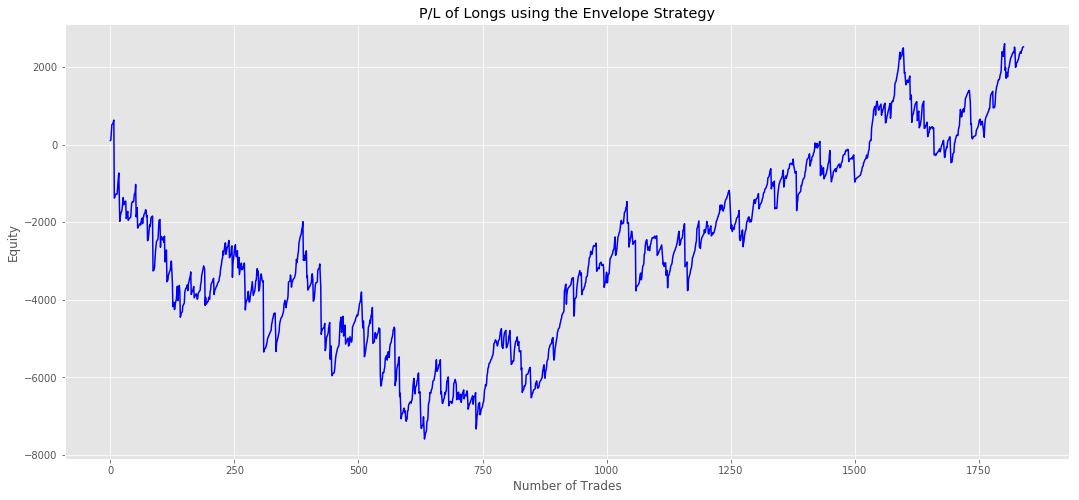

In [245]:
import matplotlib.pyplot as plt
 
plt.style.use('ggplot')

PL = pd.Series(np.cumsum(long["P/L"]))


plt.figure(figsize=(18, 8), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("P/L of Longs using the Envelope Strategy", loc='center', pad=None)
plt.ylabel("Equity");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 30})

## Stats

In [246]:
long["Time"].loc[long["TradeExecuted"].idxmax()]

'2010-01-05 12:40:00'

In [247]:
long["P/L"].loc[long["P/L"].idxmax()]

527.8030151367242

In [248]:
long["P/L"].loc[long["P/L"].idxmin()]

-2008.7487762451074

In [249]:
countEntries = long.groupby("TradeExecuted")["P/L"].count()
avgPL = long.groupby("TradeExecuted")["P/L"].mean()
avgPL = round(avgPL,1)
data = {"Count": countEntries, "P/L": avgPL}
stats=pd.DataFrame(data)
stats

,Count,P/L
TradeExecuted,,
1,310,17.9000
2,210,38.0000
3,212,56.3000
4,154,78.6000
5,144,104.4000
6,98,144.8000
7,477,-134.8000


In [250]:
print(stats["Count"].sum())
print(stats["Count"][stats.index>5].sum())

1605
575


In [251]:
import matplotlib.pyplot as plt
 
plt.style.use('ggplot')

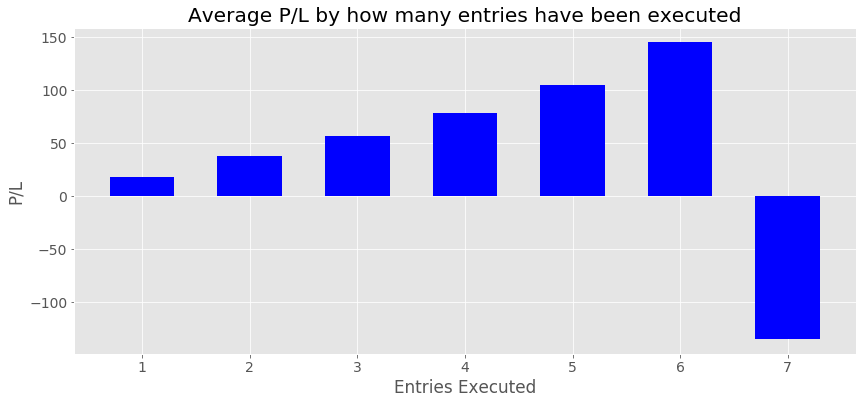

In [266]:
plt.figure(figsize=(14, 6))
# Create bars
ind = np.arange(len(stats)) 
plt.bar(ind ,stats["P/L"], color="blue", width=0.6)

plt.xticks(ind, ('1', '2', '3', '4', '5','6', '7'))
plt.xlabel("Entries Executed")
plt.ylabel("P/L")
plt.title("Average P/L by how many entries have been executed")

plt.rcParams.update({'font.size': 14})

# Show graphic
plt.show()


In [263]:
positive = long[long["P/L"]>0]
positive = positive.groupby("TradeExecuted")["P/L"].mean()
positive

TradeExecuted
1    18.0612
2    38.2102
3    58.1528
4    81.5864
5   108.6861
6   146.5471
7   131.8711
Name: P/L, dtype: float64

In [264]:
negative = long[long["P/L"]<0]
negative = negative.groupby("TradeExecuted")["P/L"].mean()
negative

TradeExecuted
1     -1.8187
2     -3.5906
3    -19.3519
4    -11.7311
5    -45.1397
6    -21.4245
7   -346.3037
Name: P/L, dtype: float64

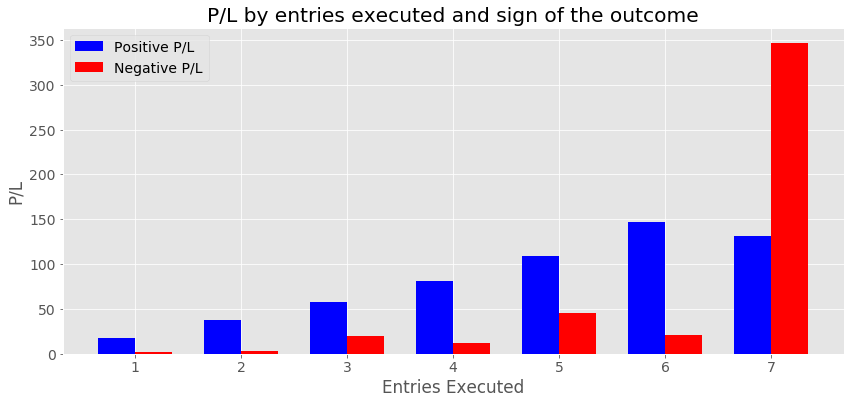

In [267]:
plt.figure(figsize=(14, 6))
ind = np.arange(len(positive)) 
width = 0.35       
plt.bar(ind, positive, width, label='Positive P/L', color="blue")
plt.bar(ind + width, abs(negative), width, label='Negative P/L', color="red")

plt.ylabel('P/L')
plt.xlabel("Entries Executed")
plt.title('P/L by entries executed and sign of the outcome')

plt.xticks(ind + width / 2, ('1', '2', '3', '4', '5','6', '7'))
plt.legend(loc='best')

plt.rcParams.update({'font.size': 14})

plt.show()